# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [1]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (D - A) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [2]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [3]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [4]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [5]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [6]:
# Check the result:

A @ x - b

array([ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
        0.00000000e+00,  2.22044605e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [7]:
def Jacobi_iter(A, b, n_iter=100):
    diag_1d = np.diag(A)

    B = -A.copy()
    np.fill_diagonal(B, 0)

    D = np.diag(diag_1d)
    invD = np.diag(1./diag_1d)
    BB = invD @ B 
    c = invD @ b
    
    x0 = np.ones(A.shape[0])
    x = x0
    for _ in range(n_iter):
        x = BB @ x + c
        
    return x, np.linalg.norm(BB, ord=np.inf)

In [8]:
rndm = np.random.RandomState(4567)

n_iter = 50
n = 10
k = 15

B_norms = []
Ax_b_norms = []

for i in range(k, 0, -1): # Будем уменьшать i и смотреть, когда появится расходимость
    A = rndm.uniform(size=(n, n)) + np.diagflat([i]*n) 
    b = rndm.uniform(size=n)

    x, B_norm = Jacobi_iter(A, b, n_iter)

    print("i =", i)
    print("The norm of B:", B_norm)
    print("The norm of Ax-b:", np.linalg.norm(A@x - b))
    
    if round(np.linalg.norm(A@x - b)) == 0:
        print("The iteration converges \n")
    else:
        print("The iteration does not converge \n")
        
    B_norms.append(B_norm)
    Ax_b_norms.append(np.linalg.norm(A@x - b))

i = 15
The norm of B: 0.37167367944829355
The norm of Ax-b: 1.9292121753525021e-16
The iteration converges 

i = 14
The norm of B: 0.37293600593709264
The norm of Ax-b: 1.601968055516711e-16
The iteration converges 

i = 13
The norm of B: 0.41995799373710285
The norm of Ax-b: 2.482534153247273e-16
The iteration converges 

i = 12
The norm of B: 0.5226828031620211
The norm of Ax-b: 2.0014830212433605e-16
The iteration converges 

i = 11
The norm of B: 0.5773501683020565
The norm of Ax-b: 1.722188176232883e-16
The iteration converges 

i = 10
The norm of B: 0.5705140430246671
The norm of Ax-b: 7.179257424810118e-15
The iteration converges 

i = 9
The norm of B: 0.6645838084563043
The norm of Ax-b: 1.6310386360175804e-14
The iteration converges 

i = 8
The norm of B: 0.7646826649057468
The norm of Ax-b: 7.970963880054843e-10
The iteration converges 

i = 7
The norm of B: 0.7305782630553815
The norm of Ax-b: 2.084999658660043e-10
The iteration converges 

i = 6
The norm of B: 1.01194601269

In [9]:
a = range(1, k+1, 1)

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, sharex="col")

ax1.set_title("The norm of B")
ax1.plot(a, list(reversed(B_norms)), label='|| B ||')
ax1.hlines(1, 1, k, color='r', label='|| B || = 1')
ax1.legend()

ax2.set_title("The norm of Ax-b")
ax2.plot(a, list(reversed(Ax_b_norms)), color='g', label='|| Ax-b ||')
ax2.set_xlabel('i', fontsize=15)
ax2.set_yscale('log')
ax2.legend()

Заключаем, что the Jacobi iteration converges, когда $\| B\| \leqslant 1$, т.е. матрица A is *diagonally dominant* (sufficient condition).

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

Given

$$
A x = b
$$

separate the diagonal part $D$, the upper triangular part $U$ and the lower tiangular part $L$,

$$ A = L + D + U $$

and write

$$
x = -D^{-1} (L+U) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = -D^{-1} (L+U) \qquad \text{and} \qquad c = D^{-1} b\;.
$$

Для исследования сходимости найдем нормы матриц

$$
B_{L} = -D^{-1}L, B_{U} = -D^{-1}U
$$

In [10]:
def Seidel_iter(A, b, n_iter=100):
    diag_1d = np.diag(A)
    
    D = np.diag(diag_1d)
    invD = np.diag(1./diag_1d)

    B_L = - invD @ np.tril(A, -1)
    B_U = - invD @ np.triu(A, 1)
    
    B = B_L + B_U
    
    x0 = np.ones(A.shape[0])
    x = x0
    
    for k in range(n_iter):
        for i in range(A.shape[0]):
            x[i] = x[i] + (b[i] - A[i,:] @ x) /A[i,i] #ищем покомпонентно
        
    return x, np.linalg.norm(B, ord=np.inf), np.linalg.norm(B_L, ord=np.inf) + np.linalg.norm(B_U, ord=np.inf)

In [11]:
rndm = np.random.RandomState(8901)

n_iter = 50
n = 10
k = 15

B_norms = []
B_LU_norms = []
Ax_b_norms = []

for i in range(k, 0, -1): # Будем уменьшать i и смотреть, когда появится расходимость
    A = rndm.uniform(size=(n, n)) + np.diagflat([i]*n) 
    b = rndm.uniform(size=n)

    x, B_norm, B_LU_norm = Seidel_iter(A, b, n_iter)

    print("i =", i)
    print("The norm of B:", B_norm)
    print("The sum of norms of B_L and B_U:", B_LU_norm)
    print("The norm of Ax-b:", np.linalg.norm(A@x - b))
    
    if round(np.linalg.norm(A@x - b)) == 0:
        print("The iteration converges \n")
    else:
        print("The iteration does not converge \n")
 
    
    B_norms.append(B_norm)
    B_LU_norms.append(B_LU_norm)
    Ax_b_norms.append(np.linalg.norm(A@x - b))

i = 15
The norm of B: 0.3880949414445036
The sum of norms of B_L and B_U: 0.6513014220870976
The norm of Ax-b: 1.5700924586837752e-16
The iteration converges 

i = 14
The norm of B: 0.34877612735793206
The sum of norms of B_L and B_U: 0.6342800325371438
The norm of Ax-b: 1.576213700060856e-16
The iteration converges 

i = 13
The norm of B: 0.3947479019313985
The sum of norms of B_L and B_U: 0.730529720095337
The norm of Ax-b: 0.0
The iteration converges 

i = 12
The norm of B: 0.4970112108759579
The sum of norms of B_L and B_U: 0.7690352378056613
The norm of Ax-b: 2.237726045655905e-16
The iteration converges 

i = 11
The norm of B: 0.5507632223338901
The sum of norms of B_L and B_U: 0.8203942915932243
The norm of Ax-b: 0.0
The iteration converges 

i = 10
The norm of B: 0.5417512898637273
The sum of norms of B_L and B_U: 0.9378297762055416
The norm of Ax-b: 1.2719202621569003e-16
The iteration converges 

i = 9
The norm of B: 0.6750999950627203
The sum of norms of B_L and B_U: 1.00371

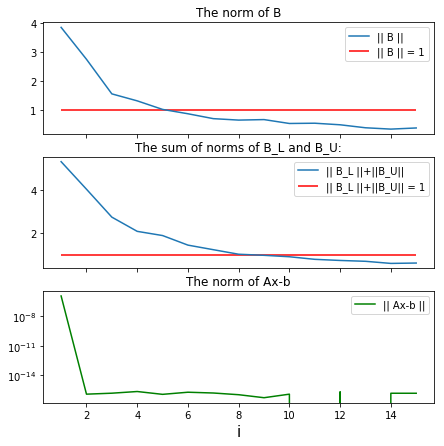

In [12]:
a = range(1, k+1, 1)

import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7), sharex="col")

ax1.set_title("The norm of B")
ax1.plot(a, list(reversed(B_norms)), label='|| B ||')
ax1.hlines(1, 1, k, color='r', label='|| B || = 1')
ax1.legend()

ax2.set_title("The sum of norms of B_L and B_U:")
ax2.plot(a, list(reversed(B_LU_norms)), label='|| B_L ||+||B_U||')
ax2.hlines(1, 1, k, color='r', label='|| B_L ||+||B_U|| = 1')
ax2.legend()

ax3.set_title("The norm of Ax-b")
ax3.plot(a, list(reversed(Ax_b_norms)), color='g', label='|| Ax-b ||')
ax3.set_xlabel('i', fontsize=15)
ax3.set_yscale('log')
ax3.legend()

При выполнении достаточного условия $\| B\| \leqslant 1$ (или более слабого $\| B_{L}\| + \|B_{U}\| \leqslant 1$) всё хорошо сходится, но и при нарушении этих условий тоже может сходиться.

Проверим выполнение *необходимого* и достаточного условия $\rho (\tilde B) < 1$, где $\tilde B = -(D+L)^{-1}U$:

In [13]:
def Seidel_iter1(A, b, n_iter=100):
    diag_1d = np.diag(A)

    D = np.diag(diag_1d)
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    
    B = -np.linalg.inv(D+L) @ U
    c = np.linalg.inv(D+L) @ b
    
    x0 = np.ones(A.shape[0])
    x = x0
    for _ in range(n_iter):
        x = B @ x + c
    
    spectrum, __ = np.linalg.eig(B)
    
    for _ in range(len(spectrum)):
        spectrum[_] = abs(spectrum[_])
        
    return x, max(spectrum)

In [14]:
rndm = np.random.RandomState(235467)

n_iter = 100
n = 10
k = 10

Rho = []
Ax_b_norms = []

for i in range(k, -k, -1): # Будем уменьшать i и смотреть, когда появится расходимость
    A = rndm.uniform(size=(n, n)) + np.diagflat([i]*n) 
    b = rndm.uniform(size=n)

    x, rho = Seidel_iter1(A, b, n_iter)

    print("i =", i)
    print("The spectral radius of B:", rho)
    print("The norm of Ax-b:", np.linalg.norm(A@x - b))
        
    if round(np.linalg.norm(A@x - b)) == 0:
        print("The iteration converges \n")
    else:
        print("The iteration does not converge \n")
         
    Rho.append(rho)
    Ax_b_norms.append(np.linalg.norm(A@x - b))

i = 10
The spectral radius of B: (0.08075227695817089+0j)
The norm of Ax-b: 4.335559509131367e-16
The iteration converges 

i = 9
The spectral radius of B: (0.11604913155044688+0j)
The norm of Ax-b: 2.7928509224031823e-16
The iteration converges 

i = 8
The spectral radius of B: (0.11842315474861274+0j)
The norm of Ax-b: 2.0955000055363631e-16
The iteration converges 

i = 7
The spectral radius of B: (0.11812284853140648+0j)
The norm of Ax-b: 2.220446049250313e-16
The iteration converges 

i = 6
The spectral radius of B: (0.14892660843261268+0j)
The norm of Ax-b: 2.9893669801409083e-16
The iteration converges 

i = 5
The spectral radius of B: (0.1979331243919973+0j)
The norm of Ax-b: 3.4219371797089426e-16
The iteration converges 

i = 4
The spectral radius of B: (0.2146297562559432+0j)
The norm of Ax-b: 2.0014830212433605e-16
The iteration converges 

i = 3
The spectral radius of B: (0.21179881983298196+0j)
The norm of Ax-b: 2.1898779786837934e-16
The iteration converges 

i = 2
The s

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


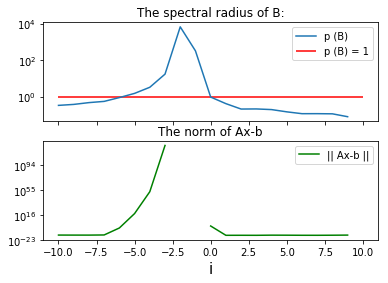

In [15]:
a = range(-k, k, 1)

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, sharex="col")

ax1.set_title("The spectral radius of B:")
ax1.plot(a, list(reversed(Rho)), label='p (B)')
ax1.hlines(1, -k, k, color='r', label='p (B) = 1')
ax1.set_yscale('log')
ax1.legend()

ax2.set_title("The norm of Ax-b")
ax2.plot(a, list(reversed(Ax_b_norms)), color='g', label='|| Ax-b ||')
ax2.set_xlabel('i', fontsize=15)
ax2.set_yscale('log')
ax2.legend()

Действительно, при $\rho(\tilde B) < 1$ the Seidel's iteration сходится.

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [26]:
def min_res(A, b, n_iter=1000):
    
    r = np.ones(A.shape[0])
    x = np.ones(A.shape[0])
    t = 0
    
    I = []
    R = []
    T = []
    error = []
    
    xx = np.linalg.solve(A, b) #True solution
    
    for i in range(1, n_iter+1):
        
        r = A@x - b
        t = r@A@r/np.linalg.norm(A@r, ord=2)**2
        x = x - t*r
        
        r_norm = np.linalg.norm(r, ord=2)
        I.append(i)
        R.append(r_norm)
        T.append(t)
        error.append(np.linalg.norm(x - xx, ord=2))
       
        if r_norm < 1e-15:
            break
            
    return x, I, R, T, error

Случай матрицы с доминирующей даигональю


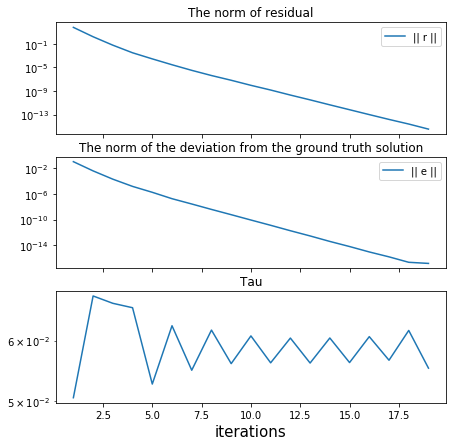

In [27]:
rndm = np.random.RandomState(4321)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)
print("Случай матрицы с доминирующей даигональю")

x, i, r, t, e = min_res(A, b)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7), sharex="col")

ax1.set_title("The norm of residual")
ax1.plot(i, r, label='|| r ||')
ax1.set_yscale('log')
ax1.legend()

ax2.set_title("The norm of the deviation from the ground truth solution")
ax2.plot(i, e, label='|| e ||')
ax2.set_yscale('log')
ax2.legend()

ax3.set_title("Tau")
ax3.plot(i, t)
ax3.set_xlabel('iterations', fontsize=15)
ax3.set_yscale('log')

Случай матрицы с менее выраженной даигональю


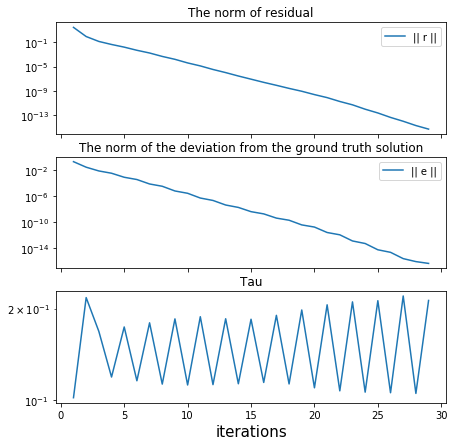

In [28]:
rndm = np.random.RandomState(4321)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([5]*n)
b = rndm.uniform(size=n)
print("Случай матрицы с менее выраженной даигональю")

x, i, r, t, e = min_res(A, b)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7), sharex="col")

ax1.set_title("The norm of residual")
ax1.plot(i, r, label='|| r ||')
ax1.set_yscale('log')
ax1.legend()

ax2.set_title("The norm of the deviation from the ground truth solution")
ax2.plot(i, e, label='|| e ||')
ax2.set_yscale('log')
ax2.legend()

ax3.set_title("Tau")
ax3.plot(i, t)
ax3.set_xlabel('iterations', fontsize=15)
ax3.set_yscale('log')

Случайная матрица с удвоенной дагональю


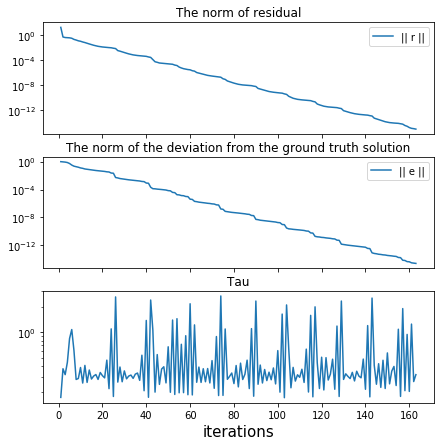

In [29]:
rndm = np.random.RandomState(4321)

n = 10
A = rndm.uniform(size=(n, n))  + np.diagflat([1]*n)
b = rndm.uniform(size=n)
print("Случайная матрица с удвоенной дагональю")

x, i, r, t, e = min_res(A, b)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7), sharex="col")

ax1.set_title("The norm of residual")
ax1.plot(i, r, label='|| r ||')
ax1.set_yscale('log')
ax1.legend()

ax2.set_title("The norm of the deviation from the ground truth solution")
ax2.plot(i, e, label='|| e ||')
ax2.set_yscale('log')
ax2.legend()

ax3.set_title("Tau")
ax3.plot(i, t)
ax3.set_xlabel('iterations', fontsize=15)
ax3.set_yscale('log')

Итерации сходятся к нужному значению, причем $\tau$ быстро осциллирует. Будем считать, что это победа.